In [3]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

数据前处理

In [6]:
#处理训练集
raw=pd.read_csv("./data/train.csv")
rawX=raw.loc[:,"XXXinorg1":"purity"]
Y=Y=np.array((raw.loc[:,"outcome"]),dtype=np.float64)
#处理测试集
raw=pd.read_csv("./data/test.csv")
human_pred=np.array(raw.loc[:,"XXX-Intuition"],dtype=np.float64)
ml_pred=np.array(raw.loc[:,"predicted outcome"],dtype=np.float64)
y=np.array(raw.loc[:,"outcome (actual)"],dtype=np.float64)
rawx=raw.loc[:,"XXXinorg1":"purity"]

In [4]:
rawXx=pd.concat([rawX,rawx])

In [6]:
featureName=list(rawXx)

对3个feature进行特判

分为实数型，字符串型，bool型

其中有三类比较特殊，需要判断：
slowCool{'?', 'no', 'yes'}

XXXoxlike1{'-1', -1, 'sodium oxalate'}

leak{'?', 'no', 'yes'}

"no" 赋为0，


In [47]:
X_featureName=[]
Xx=np.array([],dtype=np.float64).reshape(len(rawXx),-1)
boolFeature=[]
oneHotFeature=[]
errorFeature=[]
encoders={}
for i in featureName:
    try:
        feature=np.array(rawXx.loc[:,i],dtype=np.float64).reshape(-1,1)
    except:
        featureval=set(rawXx.loc[:,i])
        if(len(featureval)==1):# 只有一种值的特征，没有帮助
            continue
        elif(featureval==set(["yes","no"])):
            feature=np.array(rawXx.loc[:,i]=='yes',dtype=np.float64).reshape(-1,1)
            boolFeature.append(i)
        elif(featureval==set(["yes","no","?"])):
            valCnt=rawXx.loc[:,i].value_counts()
            ratio=(valCnt["yes"])/(valCnt['no'])
            feature=np.array((rawXx.loc[:,i]=='yes')
                +((rawXx.loc[:,i]=='?')*(ratio/(1+ratio))),dtype=np.float64).reshape(-1,1)
            boolFeature.append(i)
        else:
            print(i)
            ohe=OneHotEncoder()
            feature=ohe.fit_transform(np.array(rawXx.loc[:,i],dtype=str).reshape(-1,1)).toarray()
            if(feature.shape[1]>200):
                errorFeature.append(i)
                continue
            else:
                oneHotFeature.append(i)
                encoders[i]=ohe
    X_featureName+=[i]*(feature.shape[1])
    Xx=np.concatenate((Xx,feature),axis=1)

XXXinorg1
XXXinorg2
XXXinorg3
XXXorg1
XXXorg2
XXXoxlike1


In [7]:
X=Xx[:len(rawX),:]
x=Xx[len(rawX):,:]

In [50]:
np.save("./processedData/Xx.npy",Xx)
np.save("./processedData/X_featureName.npy",X_featureName)
np.save("./processedData/errorFeature.npy",errorFeature)
np.save("./processedData/oneHotFeature.npy",oneHotFeature)
np.save("./processedData/boolFeature.npy",boolFeature)
np.save("./processedData/encoders.npy",encoders)

SVM

对数据集进行shuffle能显著提高性能,但这是虚假的。作者需要求出未知化合物组合的效果
shuffle=True是随机取样。但是作者的策略是把同一反应物组合的化合物放到一起(恰好在csv中反应物组合近似的放在一起)。则shuffle=False即可。

但这样太不均衡，因此考虑9分类，每次取3个作为数据集

In [53]:
def numout2boolout(label):# 结果有1，2，3，4。但是3，4对应人的预测1
    return label>2.5
def crossValidation(X,y,n_splits,Model,params,shuffle=False):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    kf=KFold(n_splits=n_splits,shuffle=shuffle)
    print(params)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X_std[train_index], X_std[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model=Model(**params)
        model.fit(X_train,Y_train)
        tr_pred=model.predict(X_train)
        tr_pred=numout2boolout(tr_pred)
        Y_train=numout2boolout(Y_train)
        print("recall={:.3f}".format(recall_score(Y_train,tr_pred,average='weighted')))
        print("precision={:.3f}".format(precision_score(Y_train,tr_pred,average="weighted")))
        print("accuracy={:.3f}".format(accuracy_score(Y_train,tr_pred)))
        print("confusion matrix is")
        print(confusion_matrix(Y_train,tr_pred))
        
        pred=model.predict(X_test)
        Y_test=numout2boolout(Y_test)
        pred=numout2boolout(pred)
        print("recall={:.3f}".format(recall_score(Y_test,pred,average='weighted')))
        print("precision={:.3f}".format(precision_score(Y_test,pred,average="weighted")))
        print("accuracy={:.3f}".format(accuracy_score(Y_test,pred)))
        print("confusion matrix is")
        print(confusion_matrix(Y_test,pred))

In [10]:
classifiers = [
    (SVC,{"gamma":2, "C":1}),
    #(GaussianProcessClassifier,{"kernel":1.0 * RBF(1.0)}),# slow
    (DecisionTreeClassifier,{"max_depth":5}),
    (RandomForestClassifier,{"max_depth":5, "n_estimators":10, "max_features":1}),
    (MLPClassifier,{"alpha":1, "max_iter":1000}),
    (AdaBoostClassifier,{}),
    (GaussianNB,{}),
    (QuadraticDiscriminantAnalysis,{})]

In [13]:
for i in classifiers:
    crossValidation(X,Y,3,i[0],i[1])

{'gamma': 2, 'C': 1}
recall=0.531
precision=0.751
accuracy=0.531
confusion matrix is
[[  1 619]
 [  0 699]]
recall=0.885
precision=0.806
accuracy=0.885
confusion matrix is
[[   1  143]
 [   8 1166]]
recall=0.686
precision=0.544
accuracy=0.686
confusion matrix is
[[  2 407]
 [  7 902]]
{'kernel': 1**2 * RBF(length_scale=1)}


KeyboardInterrupt: 

文献中使用的svm https://github.com/rlphilli/sklearn-PUK-kernel/blob/master/PUK_kernel.py

以下函数是文献中使用的svm核，效果不如RBF核

In [34]:
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform

def PUK_kernel(X1,X2, sigma=1.0, omega=1.0):
    # Compute the kernel matrix between two arrays using the Pearson VII function-based universal kernel.
    
    # Compute squared euclidean distance between each row element pair of the two matrices
    if X1 is X2 :
        kernel = squareform(pdist(X1, 'sqeuclidean'))
    else:
        kernel = cdist(X1, X2, 'sqeuclidean')

    kernel = (1 + (kernel * 4 * np.sqrt(2**(1.0/omega)-1)) / sigma**2) ** omega
    kernel = 1/kernel

    return kernel

很糟，train,testset差别太大

In [10]:
crossValidation(X,Y,3,SVC,{"class_weight":"balanced","C":1})# "kernel":PUK_kernel,"C":0.1

{'class_weight': 'balanced', 'C': 1}
recall=0.862
precision=0.887
accuracy=0.862
confusion matrix is
[[ 471   82]
 [ 281 1802]]
recall=0.554
precision=0.567
accuracy=0.554
confusion matrix is
[[108 512]
 [ 76 623]]
recall=0.846
precision=0.857
accuracy=0.846
confusion matrix is
[[ 914  115]
 [ 291 1317]]
recall=0.646
precision=0.819
accuracy=0.646
confusion matrix is
[[ 59  85]
 [381 793]]
recall=0.848
precision=0.857
accuracy=0.848
confusion matrix is
[[ 621  143]
 [ 257 1616]]
recall=0.581
precision=0.597
accuracy=0.581
confusion matrix is
[[162 247]
 [305 604]]


将相同反应物的反应聚在一起再shuffle，达到了原文献的效果

In [ ]:
reactantCombination=[[0]]
for i in range(1,len(rawX)):
    if((rawX.loc[i-1,["XXXinorg1","XXXinorg2","XXXinorg3","XXXorg1","XXXorg2"]]==rawX.loc[i,["XXXinorg1","XXXinorg2","XXXinorg3","XXXorg1","XXXorg2"]]).all()):
        reactantCombination[-1].append(i)
    else:
        reactantCombination.append([i])

In [56]:
def CV_author(X,Y,n_splits,Model,params,shuffle=True):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    kf=KFold(n_splits=n_splits,shuffle=shuffle)
    print(params)
    for train_index_rc, test_index_rc in kf.split(reactantCombination):
        train_index=[i for rc  in train_index_rc  for i in reactantCombination[rc] ]
        test_index=[i for rc  in test_index_rc  for i in reactantCombination[rc]]
        X_train, X_test = X_std[train_index], X_std[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model=Model(**params)
        model.fit(X_train,Y_train)
        
        pred=model.predict(X_test)
        Y_test=numout2boolout(Y_test)
        pred=numout2boolout(pred)
        print("recall={:.3f}".format(recall_score(Y_test,pred,average='weighted')))
        print("precision={:.3f}".format(precision_score(Y_test,pred,average="weighted")))
        print("accuracy={:.3f}".format(accuracy_score(Y_test,pred)))
        print("confusion matrix is")
        print(confusion_matrix(Y_test,pred))

In [57]:
CV_author(X,Y,3,SVC,{"kernel":PUK_kernel,"class_weight":"balanced","C":1})

{'kernel': <function PUK_kernel at 0x7f9310cff430>, 'class_weight': 'balanced', 'C': 1}
recall=0.763
precision=0.784
accuracy=0.763
confusion matrix is
[[ 97 296]
 [ 17 913]]
recall=0.772
precision=0.780
accuracy=0.772
confusion matrix is
[[ 94 279]
 [ 22 927]]
recall=0.730
precision=0.769
accuracy=0.730
confusion matrix is
[[ 62 345]
 [  9 894]]


对测试集的测试

In [60]:
model=SVC(kernel=PUK_kernel,class_weight="balanced",C=1)
model.fit(X,Y)
pred=model.predict(x)
print(precision_score(numout2boolout(y),numout2boolout(pred)))

0.8152173913043478


将模型解释为决策树, 使用sklearn.tree.plot_tree进行可视化

In [74]:
def reinterpret(X_model,model,X_tree):
    pred=model.predict(X_model)
    ret=DecisionTreeClassifier()
    ret.fit(X_tree,pred)
    return ret
    

In [ ]:
def in_tree_X_mask(s):
    for i in ["orgvanderwaals","orgASA+","orghbdamsdon","PaulingElectronegMean", "hardnessMeanWeighted", "AtomicRadiusMeanWeighted"]:
        if i in s:
            return 1
    return 0

In [ ]:
tree_X_mask=[i for i in range(len(X_featureName)) if in_tree_X_mask(X_featureName[i])]


In [76]:
tree=reinterpret(X,model,X[:,tree_X_mask])

[Text(167.4, 190.26, 'purity <= 0.5\ngini = 0.708\nsamples = 3955\nvalue = [657, 532, 1493, 1273]'),
 Text(83.7, 135.9, 'XXXinorg1 <= 0.5\ngini = 0.093\nsamples = 499\nvalue = [475, 10, 5, 9]'),
 Text(41.85, 81.53999999999999, 'XXXinorg1mass <= 1.136\ngini = 0.025\nsamples = 481\nvalue = [475, 2, 1, 3]'),
 Text(20.925, 27.180000000000007, '\n  (...)  \n'),
 Text(62.775000000000006, 27.180000000000007, '\n  (...)  \n'),
 Text(125.55000000000001, 81.53999999999999, 'pH <= 4.5\ngini = 0.642\nsamples = 18\nvalue = [0, 8, 4, 6]'),
 Text(104.625, 27.180000000000007, '\n  (...)  \n'),
 Text(146.475, 27.180000000000007, '\n  (...)  \n'),
 Text(251.10000000000002, 135.9, 'XXXoxlike1mass <= 0.199\ngini = 0.655\nsamples = 3456\nvalue = [182, 522, 1488, 1264]'),
 Text(209.25, 81.53999999999999, 'hardnessMinWeighted <= 0.098\ngini = 0.642\nsamples = 3327\nvalue = [104, 514, 1457, 1252]'),
 Text(188.32500000000002, 27.180000000000007, '\n  (...)  \n'),
 Text(230.175, 27.180000000000007, '\n  (...)  

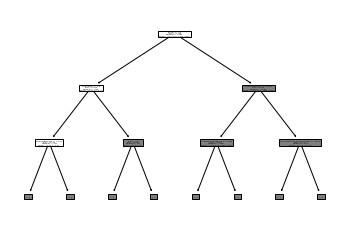

In [78]:
plot_tree(tree,max_depth=5,feature_names=[X_featureName[i] for i in tree_X_mask])

特征选择

sklearn应该没有实现CFS方法，但是可以用其他方法

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

sfm = SelectFromModel(LassoCV(), ).fit(X, y)
toc = time()
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")